In [141]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, KFold
from imblearn.over_sampling import SMOTE


In [142]:
import os
file_path = os.getcwd()
train_path = os.path.join(file_path, "데이터셋", "train.csv")
test_path = os.path.join(file_path, "데이터셋", "test.csv")
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)


<Axes: xlabel='대출 상환 기간', ylabel='count'>

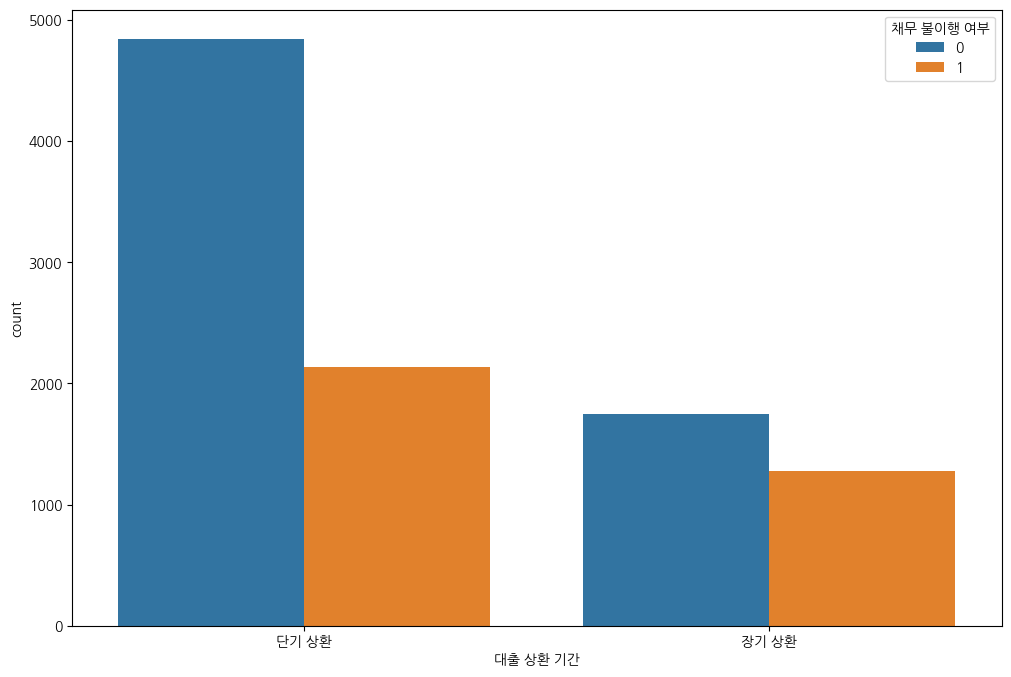

In [143]:
plt.rc("font", family = "NanumGothic")
plt.figure(figsize = (12,8))
sns.countplot(x = "대출 상환 기간", hue = "채무 불이행 여부", data = train_df)

In [144]:
from sklearn.ensemble import RandomForestRegressor
from scipy.optimize import curve_fit
def preprocess(df):
    df = df.copy()
    def year(x):
        return "".join(v.replace("이상", "").replace("년", "") for v in x.split(" "))

    def year1(x):
        return "".join(v.replace('1미만', "0") for v in x.split(" "))
    
    df["신용 거래 연수"] = df["신용 거래 연수"].astype(int)
    
    
    cols = (["주거 형태","대출 목적", "대출 상환 기간"])
    for c in cols:
        lb = LabelEncoder()
        lb.fit(df[c].values)
        df[c] = lb.transform(list(df[c].values))
        df[c] = df[c].astype(int)

 
    df["현재 직장 근속 연수"] = df["현재 직장 근속 연수"].apply(year)
    df["현재 직장 근속 연수"] = df["현재 직장 근속 연수"].apply(year1).astype(int)
    df["현재 대출 잔액"] = df["현재 대출 잔액"].where((df["현재 대출 잔액"] > 0), np.nan)
    df["현재 대출 잔액"] = df["현재 대출 잔액"].fillna(df["현재 대출 잔액"].median())
    df["최대 신용한도"] = df["최대 신용한도"].where((df["최대 신용한도"] > 0), np.nan)
    df["최대 신용한도"] = df["최대 신용한도"].fillna(df["최대 신용한도"].median())
    df["대출액+신용액"] = df["현재 대출 잔액"] + df["현재 미상환 신용액"]
    df["상환액 분위"] = pd.qcut(df["대출액+신용액"], 5, labels = [1,2,3,4,5], duplicates = "drop").astype(int)

    df["신용거래분위"] = pd.qcut(df["신용 거래 연수"], 5, labels = [1,2,3,4,5], duplicates = "drop").astype(int)
    df["신용점수분위"] = pd.qcut(df["신용 점수"], 5, labels = [1,2,3,4,5], duplicates= "drop").astype(int)

    df["연간소득분위"] = pd.qcut(df["연간 소득"], 5, labels = [1,2,3,4,5], duplicates = "drop").astype(int)
    df["개설된_신용계좌_분위수"] = pd.qcut(df["개설된 신용계좌 수"], 5, labels = [1,2,3,4,5], duplicates = "drop").astype(int)
    df["대출잔액 분위수"] = pd.qcut(df["현재 대출 잔액"], 5, labels = [1,2,3,4,5], duplicates= "drop").astype(int)
    df["직장근속연수 분위수"] = pd.qcut(df["현재 직장 근속 연수"], 7, labels = [1,2,3,4,5], duplicates= "drop").astype(int)
    df["연체 이후 경과 개월 분위수"] = pd.qcut(df["마지막 연체 이후 경과 개월 수"], 5, labels = [1,2,3,4,5], duplicates = "drop").astype(int)

    df["채무 이행 의지 없음"] = ((df["월 상환 부채액"] == 0) & (df["대출액+신용액"] > 0)).astype(int)
    

    df["신용한도vs대출잔액"] = (df["현재 대출 잔액"] + df["현재 미상환 신용액"] )  / ((df["최대 신용한도"] * df["개설된 신용계좌 수"]))* 100

    df["DTI"] = ((df["현재 대출 잔액"] + df["현재 미상환 신용액"]) / df["연간 소득"]) * 100
    df["DSR"] = (((df["월 상환 부채액"] + 1)) / (df["연간 소득"]/ 12)) * 100

    df["DTI분위"] = pd.qcut(df["DTI"], 5, labels = [1,2,3,4,5], duplicates= "drop").astype(int)
    df["DSR분위"] = pd.qcut(df["DSR"], 5, labels = [1,2,3,4,5], duplicates= "drop").astype(int)
    #df["DTI vs DTR"] = (df["DTR변형"] - df["DTI"])
    #df["DBI"] = (df["DTI"] + df["DSR"]) / 2
    #df["DTI vs DSR"] = (df["DTI"] * df["DSR"])

    df["신용위험"] = ((df["개설된_신용계좌_분위수"] >= 3) & (df["신용점수분위"] <= 3) & (df["신용거래분위"] <= 3)).astype(int)
    df["소득위험"] = ((df["직장근속연수 분위수"] < 3) & (df["연간소득분위"] < 3)).astype(int)
    df["대출위험"] = ((df["상환액 분위"] > 3) & (df["DSR분위"] < 3)).astype(int)
    df["파산위험"] = ((df["신용 문제 발생 횟수"] > 0) & ((df["개인 파산 횟수"] > 0) | (df["체납 세금 압류 횟수"] > 0))).astype(int)
    df["부채통합위험"] = ((df["대출 목적"] == 4) & (df["DTI분위"] > 3)).astype(int)
    df["부채통합위험2"] = ((df["대출 목적"] == 4) & (df["신용위험"] == 1)).astype(int)
    df["장기상환위험"] = ((df["대출 상환 기간"] == 1) & (df["신용점수분위"] < 3)).astype(int)
    df["연체위험"] = ((df["연체 이후 경과 개월 분위수"] < 3) & (df["신용점수분위"] < 3)).astype(int)

    

    df["위험분자"] = df["신용위험"] + df["소득위험"] + df["대출위험"] + df["파산위험"] + df["부채통합위험"] +df["부채통합위험2"] + df["장기상환위험"] + df["연체위험"] + df["채무 이행 의지 없음"]
    
    df["위험분자 가중치ver"] = np.exp(df["위험분자"])
    
    #df["위험분자분위"] = pd.qcut(df["위험분자"], 50, labels = [1,2,3,4,5], duplicates= "drop").astype(int)
    #df["신용점수 vs 위험분자"] = df["신용점수분위"] - df["위험분자"]

    df["분위수 계산(양)"] = df["신용거래분위"] + df["신용점수분위"] + df["직장근속연수 분위수"] + df["연간소득분위"] + df["연체 이후 경과 개월 분위수"]
    df["분위수 계산(음)"] = df["DTI분위"] + df["DSR분위"] + df["상환액 분위"] + df["대출잔액 분위수"] + df["개설된_신용계좌_분위수"] + df["위험분자"]

    df["총점수 계산"] = (df["분위수 계산(양)"] / df["분위수 계산(음)"]) * 100



    #df["VIP"] = df["신용vip"] + df["소득vip"] + df["대출vip"] + df["파산vip"] + df["부채통합아님"] + df["부채통합아님2"] + df["장기상환아님"] + df["연체아님"]

    #df["VIP vs 위험분자"] = df["VIP"] - df["위험분자"]


    df["근속연수vs거래연수"] = (df["현재 직장 근속 연수"] / df["신용 거래 연수"]) * 100


    신용점수_DTI = df.groupby("신용 점수")["DTI"].agg("mean")
    신용점수_DSR = df.groupby("신용 점수")["DSR"].agg("mean")
    df["신용점수별 평균 DTI"] = df["신용 점수"].map(신용점수_DTI)
    df["신용점수별 평균 DSR"] = df["신용 점수"].map(신용점수_DSR)
    #df["DTI 초과비율"] = (df["DTI"]/df["DTI"].mean())*100
    #df["DSR 초과비율"] = (df["DSR"]/df["DSR"].mean())*100



    #df["위험도 점수"] = df["신용점수분위"] - df["상환액 분위"]
    #df["위험도 점수2"] = df["신용거래분위"] - df["개설된_신용계좌_분위수"]
    #df["위험도 점수3"] = df["직장근속연수 분위수"] - df["대출잔액 분위수"]

    #df["문제 발생 점수"] = df["신용 문제 발생 횟수"] + df["개인 파산 횟수"] + df["체납 세금 압류 횟수"]


    #df["VIP"] = ((df["개설된_신용계좌_분위수"] > 3) & (df["신용점수분위"] > 3)).astype(int)


    df["개설계좌vs연체이후개월수"] = df["개설된 신용계좌 수"] / (df["마지막 연체 이후 경과 개월 수"] + 1) * 100

    #df["위험분자 vs 신용점수"] = df["신용 점수"] / df["위험분자 가중치ver"]

    #df["이동평균 경과 개월 수"] = df["마지막 연체 이후 경과 개월 수"].rolling(window = 3).mean()
    #df["이동평균 경과 개월 수"] = df["이동평균 경과 개월 수"].fillna(df["이동평균 경과 개월 수"].median())
    #df["이동평균 신용점수"] = df["신용 점수"].rolling(window = 3).mean()
    #df["이동평균 신용점수"] = df["이동평균 신용점수"].fillna(df["이동평균 신용점수"].median())



    신용거래 = df.groupby("개설된 신용계좌 수")["신용 거래 연수"].agg("mean")
    #df["신용거래연수_개설신용계좌"] = df["개설된 신용계좌 수"].map(신용거래)
    신용대출 = df.groupby("개설된 신용계좌 수")["현재 대출 잔액"].agg("mean")
    #df["신용계좌vs대출잔액"] = df["개설된 신용계좌 수"].map(신용대출)
    #df["신용계좌vs대출잔액"] = df["신용계좌vs대출잔액"] / 10000
    
    bankcount_purpose = df.groupby("대출 목적")["개설된 신용계좌 수"].agg("median")
    purpose_bankcount = df.groupby("개설된 신용계좌 수")["연간 소득"].agg("median")
    #df["계좌수별_소득"] = df["개설된 신용계좌 수"].map(purpose_bankcount)
    #df["계좌수별_소득"] = df["계좌수별_소득"].astype(int)  

    df = df.drop(["대출액+신용액", "DSR분위", "DTI분위", "상환액 분위", "신용점수별 평균 DTI", "신용점수별 평균 DSR", "위험분자 가중치ver"], axis = 1)
    
    return df

train = preprocess(train_df)
test = preprocess(test_df)
train.head()



,UID,주거 형태,연간 소득,현재 직장 근속 연수,체납 세금 압류 횟수,개설된 신용계좌 수,신용 거래 연수,최대 신용한도,신용 문제 발생 횟수,마지막 연체 이후 경과 개월 수,...,부채통합위험,부채통합위험2,장기상환위험,연체위험,위험분자,분위수 계산(양),분위수 계산(음),총점수 계산,근속연수vs거래연수,개설계좌vs연체이후개월수
0,TRAIN_00000,1,1941337.5,10,0.0,9,13,400597.5,0,24,...,0,0,0,0,0,14,9,155.555556,76.923077,36.000000
1,TRAIN_00001,0,1979505.0,10,0.0,5,15,360679.5,0,11,...,1,0,0,0,1,14,19,73.684211,66.666667,41.666667
2,TRAIN_00002,0,1356381.0,4,0.0,12,18,491770.5,1,74,...,1,0,0,0,3,17,17,100.000000,22.222222,16.000000
3,TRAIN_00003,0,1049017.5,6,0.0,15,14,411546.0,1,22,...,1,0,0,0,2,12,18,66.666667,42.857143,65.217391
4,TRAIN_00004,0,4320217.5,2,0.0,11,26,895288.5,0,32,...,0,0,0,0,1,16,16,100.000000,7.692308,33.333333


In [145]:
train.columns

Index(['UID', '주거 형태', '연간 소득', '현재 직장 근속 연수', '체납 세금 압류 횟수', '개설된 신용계좌 수',
       '신용 거래 연수', '최대 신용한도', '신용 문제 발생 횟수', '마지막 연체 이후 경과 개월 수', '개인 파산 횟수',
       '대출 목적', '대출 상환 기간', '현재 대출 잔액', '현재 미상환 신용액', '월 상환 부채액', '신용 점수',
       '채무 불이행 여부', '신용거래분위', '신용점수분위', '연간소득분위', '개설된_신용계좌_분위수', '대출잔액 분위수',
       '직장근속연수 분위수', '연체 이후 경과 개월 분위수', '채무 이행 의지 없음', '신용한도vs대출잔액', 'DTI',
       'DSR', '신용위험', '소득위험', '대출위험', '파산위험', '부채통합위험', '부채통합위험2', '장기상환위험',
       '연체위험', '위험분자', '분위수 계산(양)', '분위수 계산(음)', '총점수 계산', '근속연수vs거래연수',
       '개설계좌vs연체이후개월수'],
      dtype='object')

In [146]:
test["신용한도vs대출잔액"].describe()

count    2062.000000
mean       15.134780
std        17.556151
min         0.010673
25%         6.365066
50%        10.496534
75%        17.236795
max       260.995028
Name: 신용한도vs대출잔액, dtype: float64

<Axes: xlabel='신용점수분위', ylabel='count'>

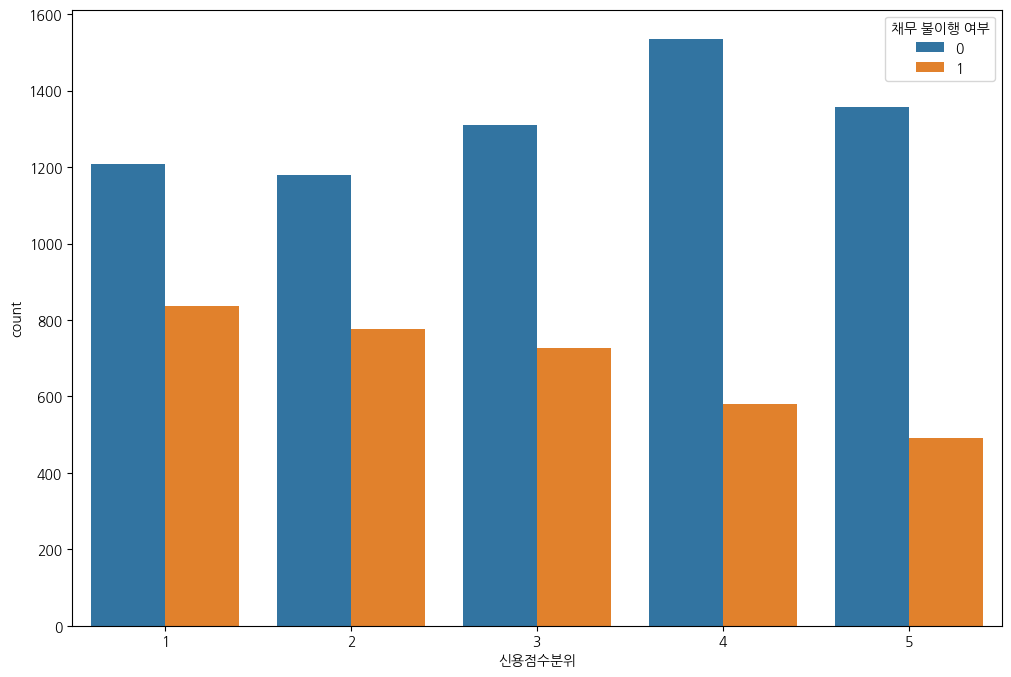

In [147]:
plt.rc("font", family = "NanumGothic")
plt.figure(figsize = (12,8))
sns.countplot(x = "신용점수분위", hue = "채무 불이행 여부", data = train)

In [148]:
from scipy.stats import boxcox
from scipy.special import boxcox1p

cols = ["연간 소득", "월 상환 부채액", "현재 대출 잔액", "현재 미상환 신용액", "신용 점수", "DTI", "DSR", "개설된 신용계좌 수", "신용 거래 연수", "근속연수vs거래연수", "개설계좌vs연체이후개월수", "신용한도vs대출잔액", "최대 신용한도", "총점수 계산"]
for c in cols:
    train[c] = train[c].where((train[c] > 0), np.nan)
    test[c] = test[c].where((test[c] > 0), np.nan)
    train[c] = train[c].fillna(train[c].median())
    test[c] = test[c].fillna(test[c].median())
    
    train[c], l = boxcox(train[c])
    test[c]= boxcox(test[c], lmbda = l)
print(train[cols].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   연간 소득          10000 non-null  float64
 1   월 상환 부채액       10000 non-null  float64
 2   현재 대출 잔액       10000 non-null  float64
 3   현재 미상환 신용액     10000 non-null  float64
 4   신용 점수          10000 non-null  float64
 5   DTI            10000 non-null  float64
 6   DSR            10000 non-null  float64
 7   개설된 신용계좌 수     10000 non-null  float64
 8   신용 거래 연수       10000 non-null  float64
 9   근속연수vs거래연수     10000 non-null  float64
 10  개설계좌vs연체이후개월수  10000 non-null  float64
 11  신용한도vs대출잔액     10000 non-null  float64
 12  최대 신용한도        10000 non-null  float64
 13  총점수 계산         10000 non-null  float64
dtypes: float64(14)
memory usage: 1.1 MB
None


C:\Users\yunju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\events.py:82: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  func(*args, **kwargs)
C:\Users\yunju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


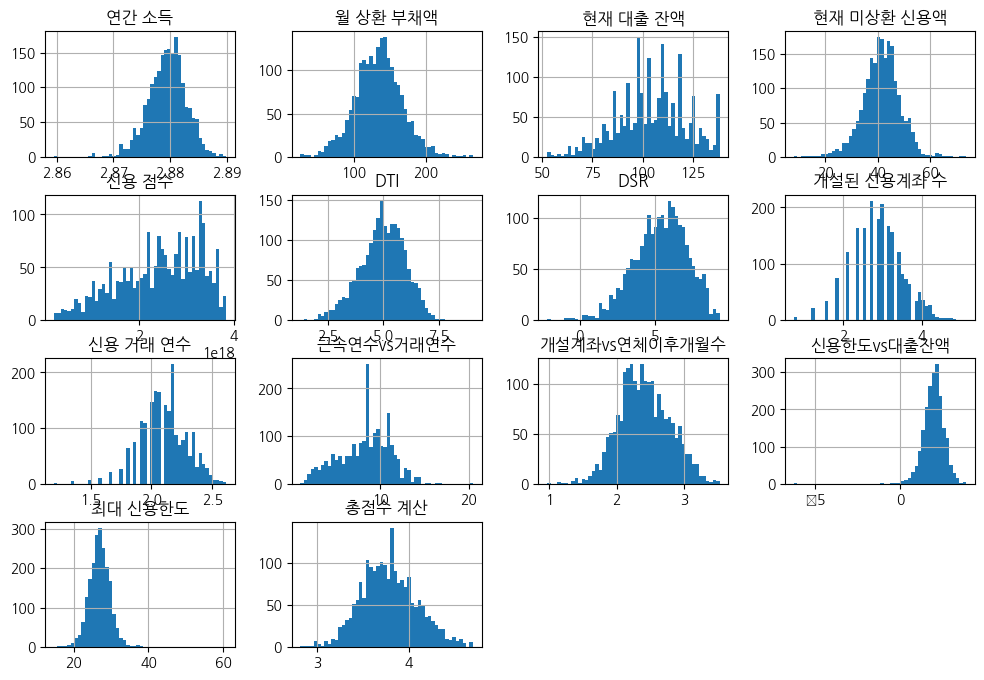

In [149]:
import matplotlib.font_manager as fm

plt.rc("font", family = "NanumGothic")

test[cols].hist(figsize = (12,8), bins = 50);

In [150]:
target = train["채무 불이행 여부"]
uid = test["UID"]

train = train.drop(["채무 불이행 여부", "UID"], axis = 1)
test = test.drop("UID", axis = 1)

In [151]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 41 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   주거 형태              10000 non-null  int32  
 1   연간 소득              10000 non-null  float64
 2   현재 직장 근속 연수        10000 non-null  int32  
 3   체납 세금 압류 횟수        10000 non-null  float64
 4   개설된 신용계좌 수         10000 non-null  float64
 5   신용 거래 연수           10000 non-null  float64
 6   최대 신용한도            10000 non-null  float64
 7   신용 문제 발생 횟수        10000 non-null  int64  
 8   마지막 연체 이후 경과 개월 수  10000 non-null  int64  
 9   개인 파산 횟수           10000 non-null  int64  
 10  대출 목적              10000 non-null  int32  
 11  대출 상환 기간           10000 non-null  int32  
 12  현재 대출 잔액           10000 non-null  float64
 13  현재 미상환 신용액         10000 non-null  float64
 14  월 상환 부채액           10000 non-null  float64
 15  신용 점수              10000 non-null  float64
 16  신용거래분위             1000

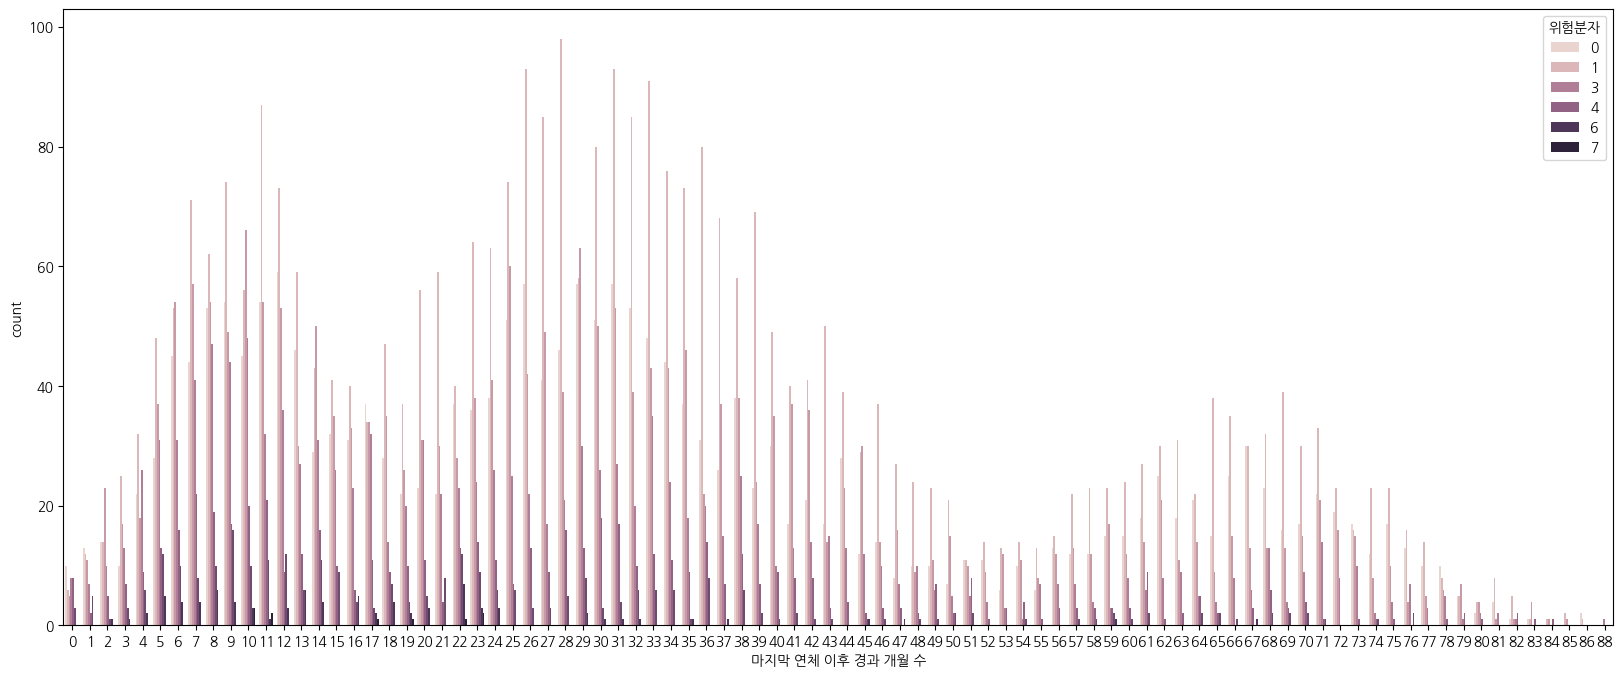

In [152]:
from matplotlib.ticker import FuncFormatter
plt.figure(figsize = (20,8))
sns.countplot(x = "마지막 연체 이후 경과 개월 수", hue = "위험분자", data = train)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:0001.0f}'))
plt.show()

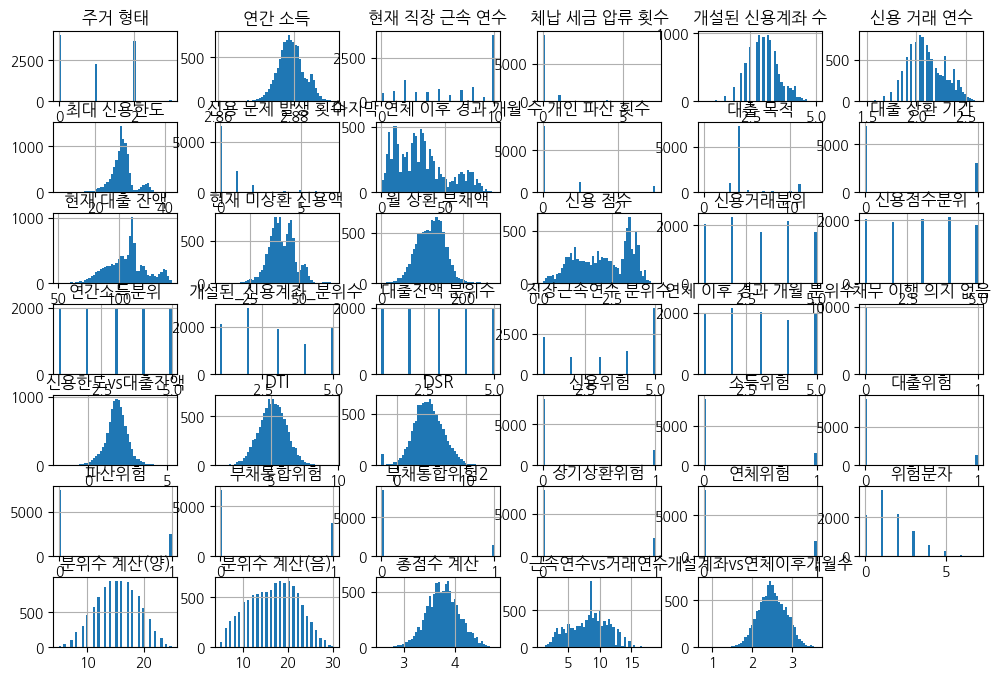

In [153]:
train.hist(figsize = (12,8),bins = 50);

C:\Users\yunju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()


<Axes: >

C:\Users\yunju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\events.py:82: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  func(*args, **kwargs)
C:\Users\yunju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


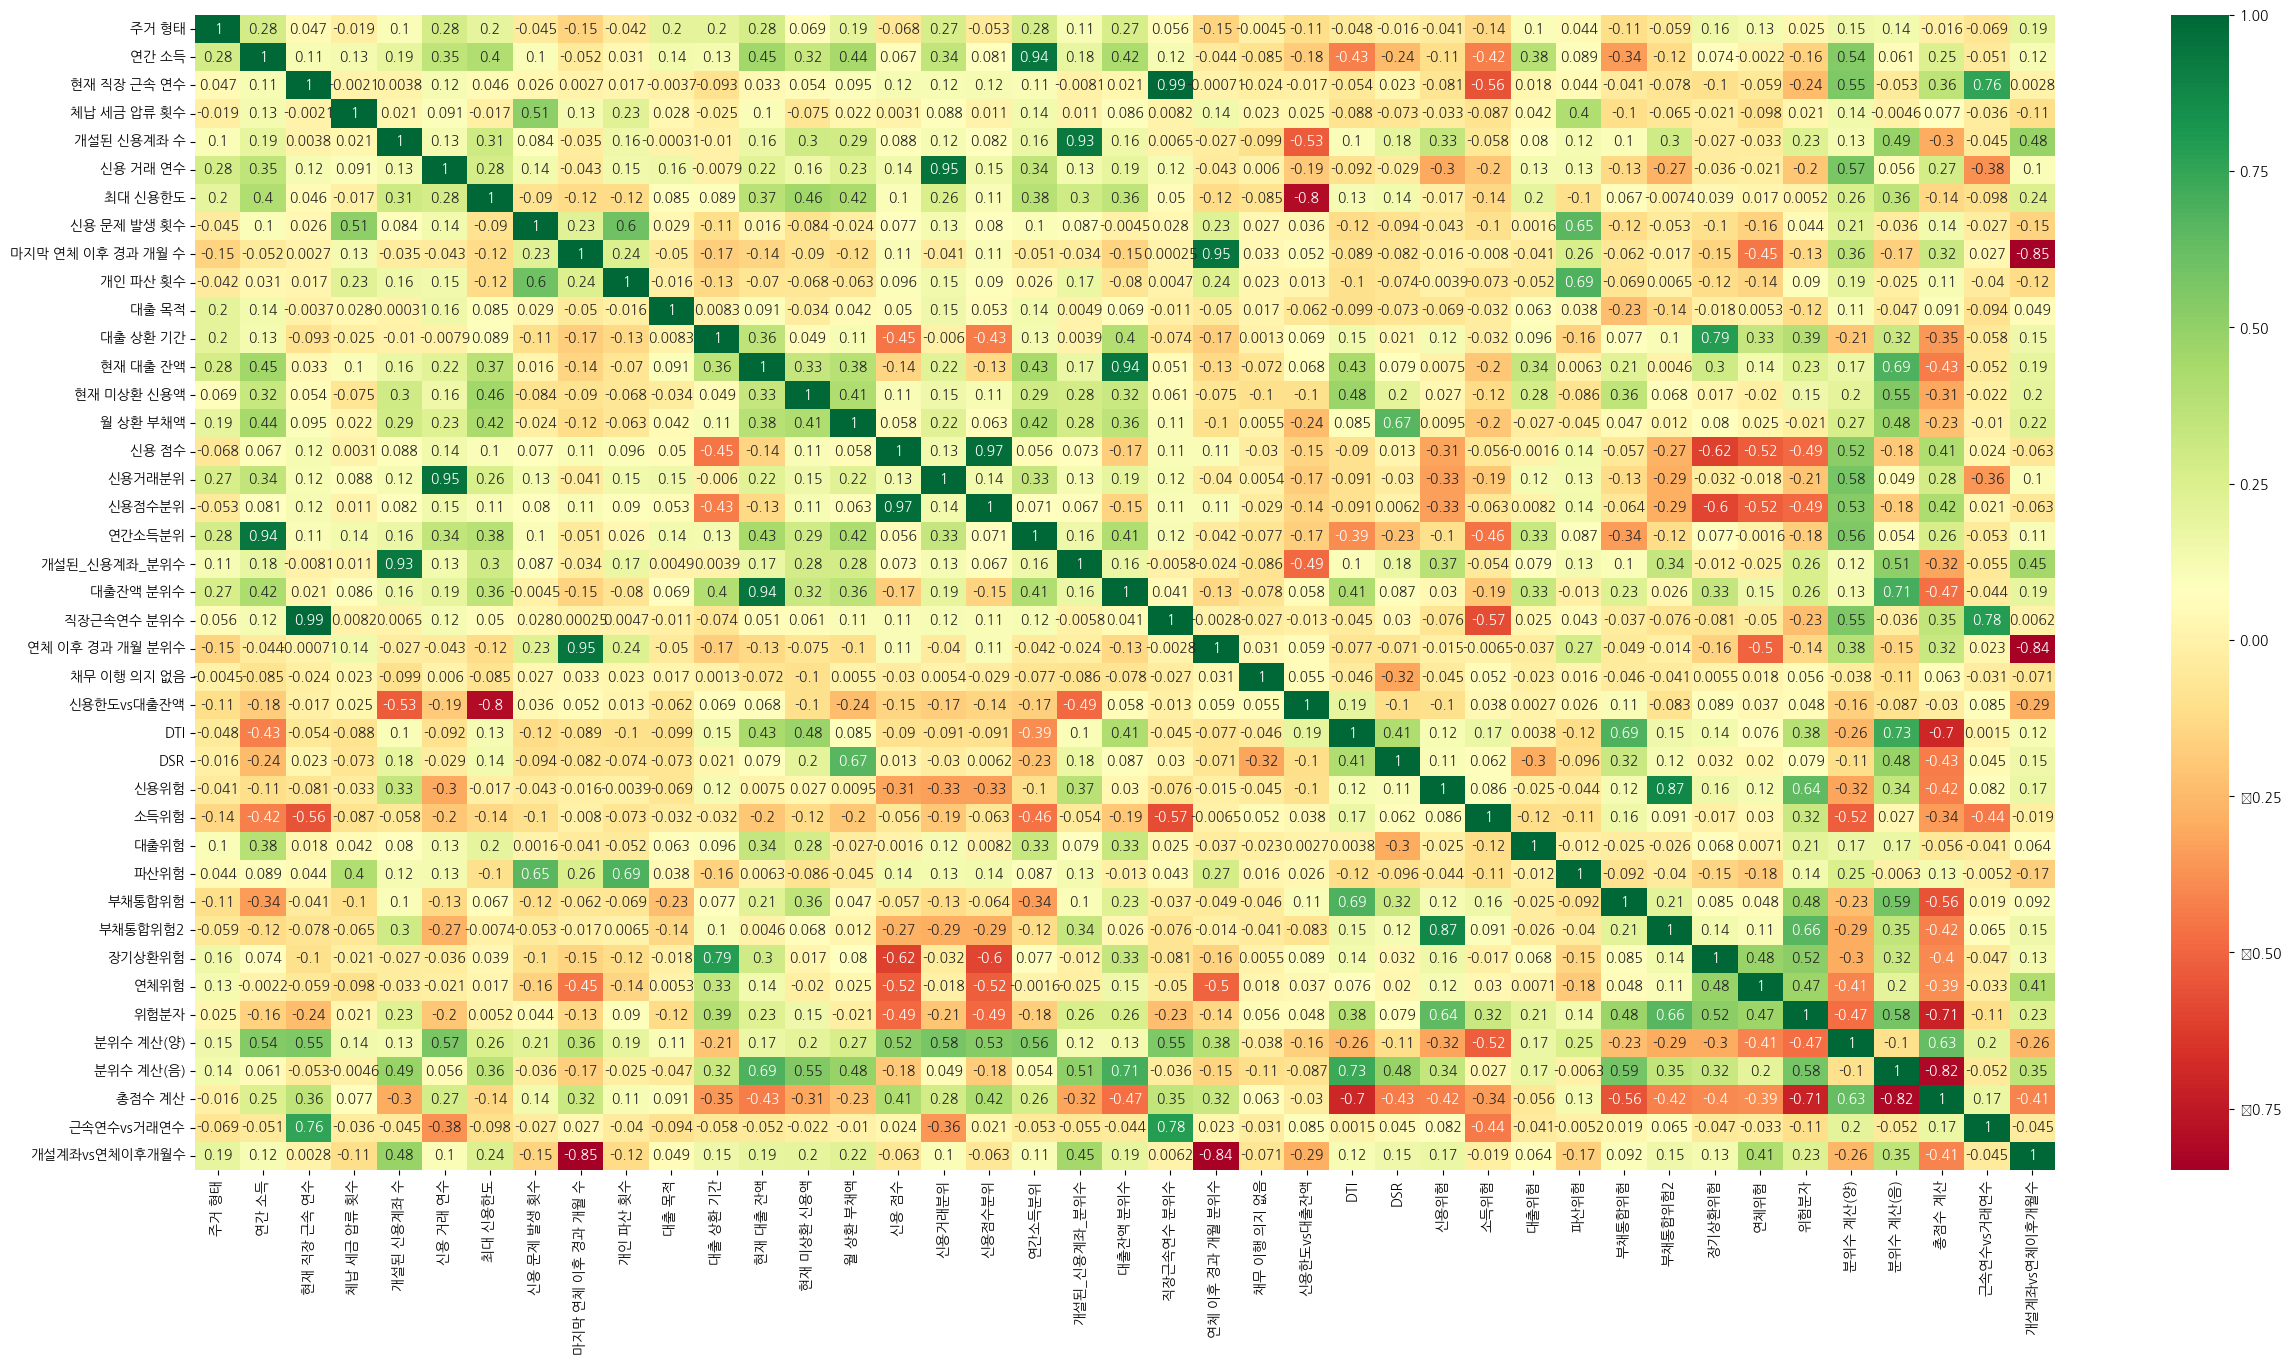

In [154]:
corrmat = train.corr()
corr_cols = corrmat.index[abs(corrmat["위험분자"] >= 0.1)]
plt.figure(figsize = (30,15))
sns.heatmap(train.corr(), annot = True, cmap = "RdYlGn")

In [155]:
train[cols].describe()

,연간 소득,월 상환 부채액,현재 대출 잔액,현재 미상환 신용액,신용 점수,DTI,DSR,개설된 신용계좌 수,신용 거래 연수,근속연수vs거래연수,개설계좌vs연체이후개월수,신용한도vs대출잔액,최대 신용한도,총점수 계산
count,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,2.879252,121.469908,106.947209,41.396724,2.213053e+18,5.124920,4.610765,3.091183,2.132955,8.320381,2.498622,1.812153,27.687612,3.773476
std,0.003492,34.254658,16.404588,6.755067,9.150231e+17,1.033056,2.201255,0.589468,0.185377,3.017711,0.348053,0.721252,3.441236,0.321973
min,2.860570,0.439571,50.907395,10.036393,1.460260e+17,1.172243,-2.196398,0.739144,1.478490,1.052152,0.795464,-1.885354,9.454365,2.556548
25%,2.877004,96.981417,95.956774,36.999796,1.388818e+18,4.442472,3.194370,2.706044,1.997558,6.105500,2.266837,1.418606,26.055129,3.561794
50%,2.879109,123.272652,108.435283,40.928808,2.232445e+18,5.130484,4.548773,3.148094,2.118524,8.522790,2.487169,1.827222,27.682038,3.767241
75%,2.881363,145.131711,115.023128,45.863310,3.068984e+18,5.820123,6.010768,3.507406,2.280443,10.529483,2.742908,2.230454,29.031378,3.986438
max,2.890255,275.743292,143.795523,67.417392,3.994169e+18,9.639172,14.056910,5.013910,2.623394,18.753989,3.605826,5.330435,42.084575,4.778760


In [156]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 41 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   주거 형태              10000 non-null  int32  
 1   연간 소득              10000 non-null  float64
 2   현재 직장 근속 연수        10000 non-null  int32  
 3   체납 세금 압류 횟수        10000 non-null  float64
 4   개설된 신용계좌 수         10000 non-null  float64
 5   신용 거래 연수           10000 non-null  float64
 6   최대 신용한도            10000 non-null  float64
 7   신용 문제 발생 횟수        10000 non-null  int64  
 8   마지막 연체 이후 경과 개월 수  10000 non-null  int64  
 9   개인 파산 횟수           10000 non-null  int64  
 10  대출 목적              10000 non-null  int32  
 11  대출 상환 기간           10000 non-null  int32  
 12  현재 대출 잔액           10000 non-null  float64
 13  현재 미상환 신용액         10000 non-null  float64
 14  월 상환 부채액           10000 non-null  float64
 15  신용 점수              10000 non-null  float64
 16  신용거래분위             1000

In [157]:
from sklearn.preprocessing import MinMaxScaler

minmax = MinMaxScaler()
X_scaled = minmax.fit_transform(train)
test_scaled = minmax.transform(test)
"""
standard = StandardScaler()
X_scaled = standard.fit_transform(train)
test_scaled = standard.transform(test)
"""

'\nstandard = StandardScaler()\nX_scaled = standard.fit_transform(train)\ntest_scaled = standard.transform(test)\n'

In [158]:
smote = SMOTE(random_state= 42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, target)

Fold 1 시작!
Epoch 1/100


C:\Users\yunju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4957 - loss: 0.7064 - val_accuracy: 0.4966 - val_loss: 0.6942
Epoch 2/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5045 - loss: 0.6976 - val_accuracy: 0.5516 - val_loss: 0.6888
Epoch 3/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5238 - loss: 0.6921 - val_accuracy: 0.5960 - val_loss: 0.6844
Epoch 4/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5296 - loss: 0.6906 - val_accuracy: 0.6077 - val_loss: 0.6805
Epoch 5/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5515 - loss: 0.6862 - val_accuracy: 0.6165 - val_loss: 0.6769
Epoch 6/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5567 - loss: 0.6840 - val_accuracy: 0.6305 - val_loss: 0.6731
Epoch 7/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5686 - loss: 0.6812 - val_accuracy: 0.6316 - val_loss: 0.6695
Epoch 8/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5638 - loss: 0.6804 - val_accuracy: 0.6354

C:\Users\yunju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4978 - loss: 0.7151 - val_accuracy: 0.5002 - val_loss: 0.6887
Epoch 2/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5115 - loss: 0.6984 - val_accuracy: 0.5518 - val_loss: 0.6794
Epoch 3/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5231 - loss: 0.6903 - val_accuracy: 0.6194 - val_loss: 0.6734
Epoch 4/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5525 - loss: 0.6823 - val_accuracy: 0.6304 - val_loss: 0.6686
Epoch 5/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5689 - loss: 0.6778 - val_accuracy: 0.6319 - val_loss: 0.6646
Epoch 6/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5699 - loss: 0.6760 - val_accuracy: 0.6387 - val_loss: 0.6607
Epoch 7/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5978 - loss: 0.6695 - val_accuracy: 0.6410 - val_loss: 0.6571
Epoch 8/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5979 - loss: 0.6666 - val_accuracy: 0.6436

C:\Users\yunju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4873 - loss: 0.7009 - val_accuracy: 0.5097 - val_loss: 0.6929
Epoch 2/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5080 - loss: 0.6964 - val_accuracy: 0.5450 - val_loss: 0.6882
Epoch 3/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5162 - loss: 0.6928 - val_accuracy: 0.5791 - val_loss: 0.6842
Epoch 4/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5261 - loss: 0.6901 - val_accuracy: 0.6019 - val_loss: 0.6804
Epoch 5/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5594 - loss: 0.6833 - val_accuracy: 0.6065 - val_loss: 0.6768
Epoch 6/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5565 - loss: 0.6831 - val_accuracy: 0.6137 - val_loss: 0.6732
Epoch 7/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5577 - loss: 0.6797 - val_accuracy: 0.6205 - val_loss: 0.6696
Epoch 8/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5755 - loss: 0.6761 - val_accuracy: 0.6266

C:\Users\yunju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4902 - loss: 0.7682 - val_accuracy: 0.5028 - val_loss: 0.7168
Epoch 2/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4972 - loss: 0.7227 - val_accuracy: 0.5013 - val_loss: 0.7003
Epoch 3/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5041 - loss: 0.7044 - val_accuracy: 0.5207 - val_loss: 0.6917
Epoch 4/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5030 - loss: 0.6991 - val_accuracy: 0.5731 - val_loss: 0.6858
Epoch 5/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5323 - loss: 0.6902 - val_accuracy: 0.5852 - val_loss: 0.6807
Epoch 6/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5595 - loss: 0.6850 - val_accuracy: 0.6019 - val_loss: 0.6759
Epoch 7/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5613 - loss: 0.6796 - val_accuracy: 0.6110 - val_loss: 0.6713
Epoch 8/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5792 - loss: 0.6755 - val_accuracy: 0.6216

C:\Users\yunju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5058 - loss: 0.7195 - val_accuracy: 0.5074 - val_loss: 0.6944
Epoch 2/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5063 - loss: 0.7021 - val_accuracy: 0.5431 - val_loss: 0.6838
Epoch 3/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5227 - loss: 0.6950 - val_accuracy: 0.5841 - val_loss: 0.6777
Epoch 4/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5261 - loss: 0.6911 - val_accuracy: 0.6091 - val_loss: 0.6728
Epoch 5/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5526 - loss: 0.6831 - val_accuracy: 0.6235 - val_loss: 0.6686
Epoch 6/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5565 - loss: 0.6821 - val_accuracy: 0.6254 - val_loss: 0.6644
Epoch 7/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5705 - loss: 0.6789 - val_accuracy: 0.6319 - val_loss: 0.6605
Epoch 8/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5804 - loss: 0.6736 - val_accuracy: 0.6398

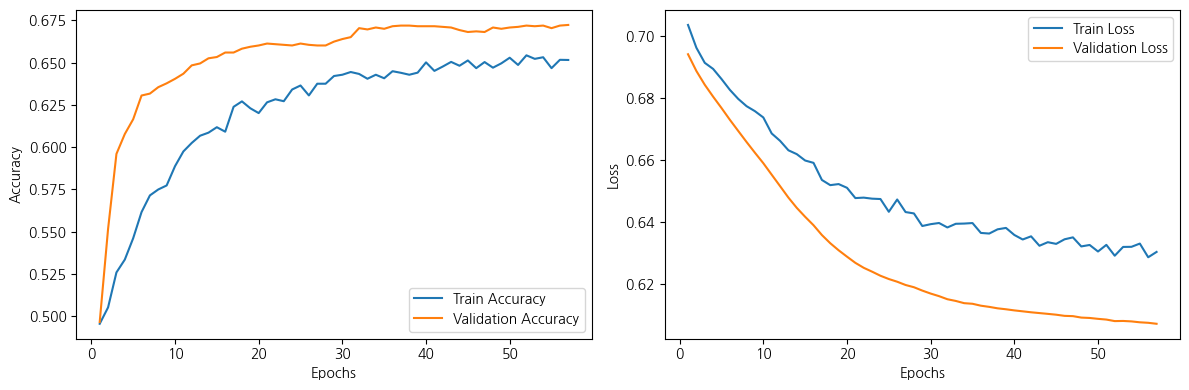

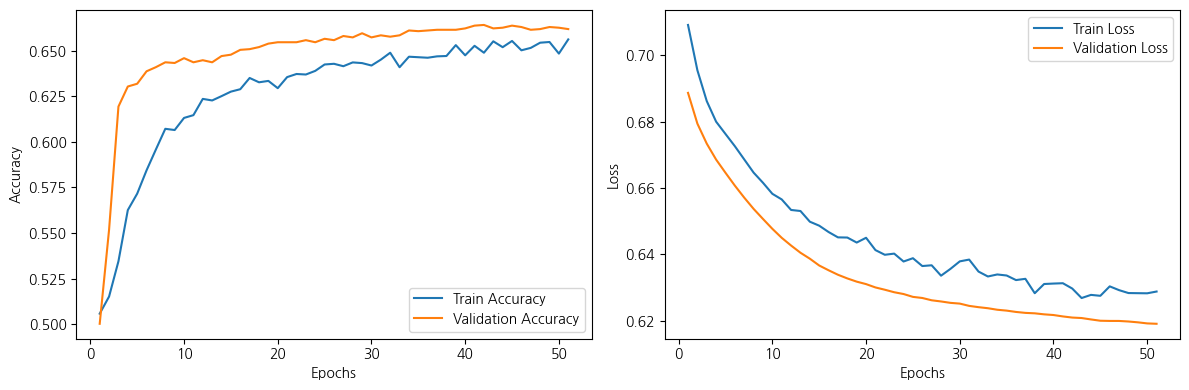

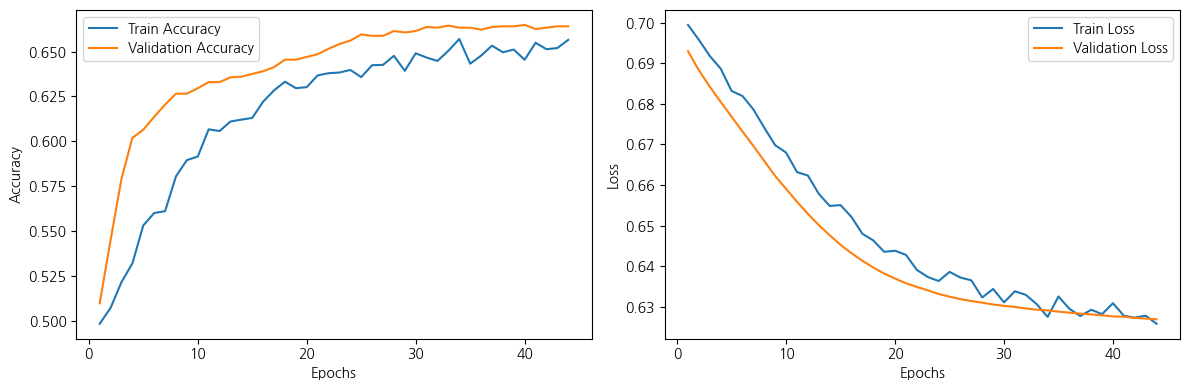

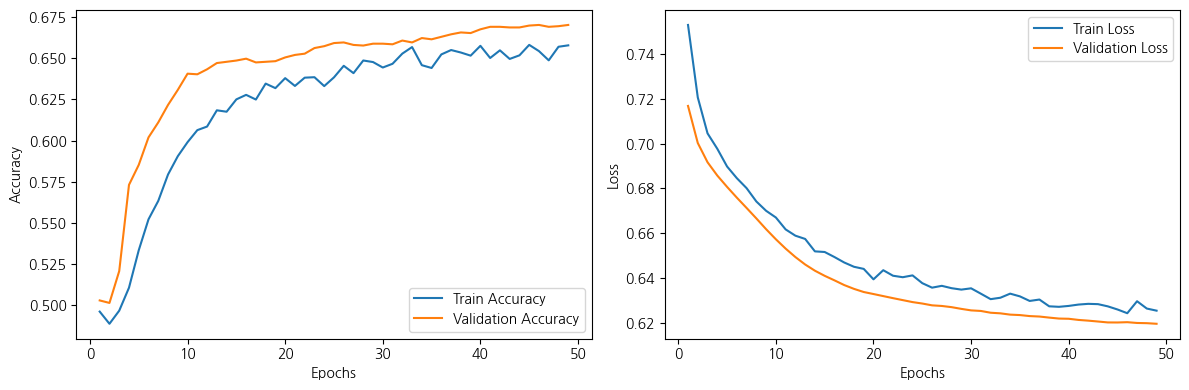

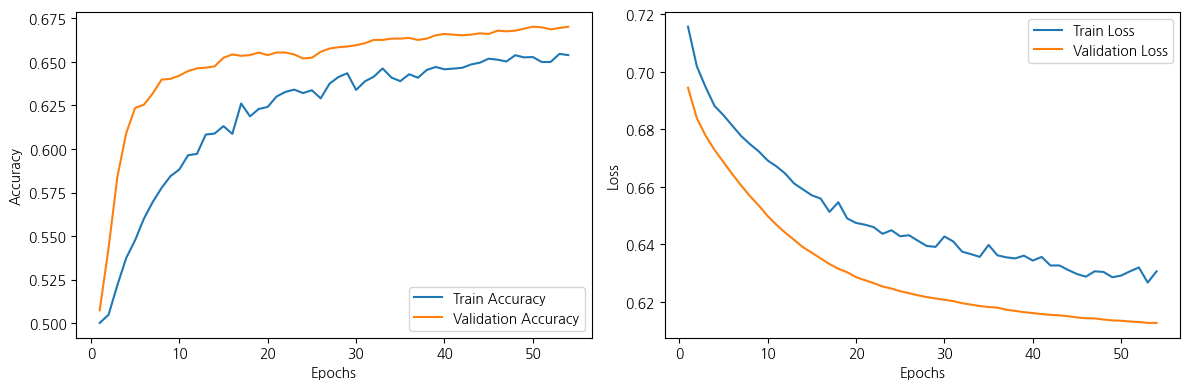

In [159]:
all_history = []
kf = KFold(n_splits = 5, shuffle= True, random_state= 42)
fold = 1
roc_auc_scores = []

for train_index, valid_index in kf.split(X_resampled):
    print(f"Fold {fold} 시작!")
    
    X_train_fold, X_valid_fold = X_resampled[train_index], X_resampled[valid_index]
    y_train_fold, y_valid_fold = y_resampled[train_index], y_resampled[valid_index]

    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation = "relu", input_shape = (X_train_fold.shape[1],)),
        tf.keras.layers.Dropout(0.30),
        tf.keras.layers.Dense(64, activation = "relu"),
        tf.keras.layers.Dropout(0.30),
        tf.keras.layers.Dense(32, activation = "relu"),
        tf.keras.layers.Dense(1, activation= "sigmoid")
    ])

    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate= 1e-5),
        loss = "binary_crossentropy",
        metrics = ["accuracy"]
    )

    earlystop = tf.keras.callbacks.EarlyStopping(
        monitor = "val_loss",
        patience = 5,
        min_delta = 0.001,
        restore_best_weights = True
    )

    history = model.fit(
        X_train_fold, y_train_fold,
        validation_data = (X_valid_fold, y_valid_fold),
        epochs = 100,
        callbacks = earlystop,
        batch_size = 32,
        verbose = 1
    )
    all_history.append(history.history)
    y_valid_pred = model.predict(X_valid_fold).ravel()
    roc_auc = roc_auc_score(y_valid_fold, y_valid_pred)
    print(f"Fold{fold} ROC-AUC score {roc_auc:.4f}")
    roc_auc_scores.append(roc_auc)
    fold += 1

print(f"교차 검증 ROC-AUC 평균점수 {np.mean(roc_auc_scores):.4f}")

for i, history in enumerate(all_history):
    epochs = range(1, len(history["loss"]) + 1)
    plt.figure(figsize = (12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, history["accuracy"], label = "Train Accuracy")
    plt.plot(epochs, history["val_accuracy"], label = "Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, history["loss"], label = "Train Loss")
    plt.plot(epochs, history["val_loss"], label = "Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [160]:
pred = model.predict(test_scaled).ravel()

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step


In [161]:
pred = model.predict(test_scaled).ravel()

sub_path = os.path.join(file_path, "데이터셋", "sample_submission.csv")
submission1 = pd.read_csv(sub_path)

submission1["채무 불이행 확률"] = pred * 100
submission1.to_csv("C:/Users/yunju/OneDrive/바탕 화면/submissions/채무불이행 예측/submission11.csv", index = False) 

"""
submission = pd.DataFrame({"UID": uid, "채무 불이행 확률": pred * 100 })
submission.to_csv("C:/Users/yunju/OneDrive/바탕 화면/submissions/채무불이행 예측/submission10.csv", index = False)
"""
submission1.head()

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step


,UID,채무 불이행 확률
0,TEST_0000,58.965977
1,TEST_0001,44.087742
2,TEST_0002,46.852463
3,TEST_0003,32.425278
4,TEST_0004,46.652775
